In [2]:
import xarray as xr
import os
import glob
import numpy as np
import warnings
import matplotlib.pyplot as plt
import sys
sys.path.append(os.path.abspath('../src'))
from processing import *
from grid_tools import compare

from dask.diagnostics import ProgressBar
warnings.filterwarnings("ignore", category=RuntimeWarning)

%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Assimilation problem setup
Here we consider assimilation of parameters in global ocean model OM4. We choose the time increment as 5 years and initialize the ocean models with World Ocean Atlas (WOA) data. Within the 5-year time increment, we evaluate the control simulation. Analysis of the model error of the control simulation w.r.t. WOA is used to perturb parameters and run a new simulation on the same time interval. The difference between the perturbed and control simulation, that is, the response pattern, is used to update the Jacobian matrix. On the next 5-year time cycle, we use the best combination of parameters obtained on the previous 5-year interval and repeat this process continuously for ~60 years. Mathematically, such iteration scheme corresponds to applying the Broyden optimization method to parameter assimilation.

We are solving the following assimilation problem:
$$
\mathcal{L}(u) = \frac{||T(u) - T_{WOA}||_2^2}{||T_{WOA}||_2^2} + \frac{||S(u) - S_{WOA}||_2^2}{||S_{WOA}||_2^2}
$$
$$
\mathcal{L}(u) \rightarrow \min_{u}
$$
where $u$ is a parameter vector (1-10 parameters). $T_{WOA}$ and $S_{WOA}$ are the annual-average WOA13 3D fields of temperature and salinity, respectively. We use a typical WOA horizontal grid (1 degree) and a typical MOM6 output vertical grid (~ 30 vertical layers). For  the model output, we apply the temporal averaging over the last 3 years of the 5-year window. This specific inverse problem can be given in a general form:
$$
\mathcal{L}(u) = ||G(u) - y_{obs}||_2^2 \rightarrow \min_u,
$$
where 
$$
G(u) = \begin{bmatrix}
T(u) / ||T_{WOA} - \overline{T}^{xyz}_{WOA}||_2 \\
S(u) / ||\overline{S}^{xyz}_{WOA}||_2
\end{bmatrix}
$$
and the observation is:
$$
y_{obs} = \begin{bmatrix}
T_{WOA} / ||\overline{T}^{xyz}_{WOA}||_2 \\
S_{WOA} / ||\overline{S}^{xyz}_{WOA}||_2
\end{bmatrix}
$$
In the loss function, the numerator is not sensitive to the units (Celsius or Kelvin). However, the denominator is sensitive. Thus, we use the normalization constant that is not sensitive to unit by subtracting the global mean from it, denoted as $\overline{(\cdot)}^{xyz}$. We do the same with salinity fields. We also premultiply the vectors pointwise with the square root of the volume of the grid cell to ensure that all scalar products account for the metric factors. Another preprocessing - we remove the Mediterranean and black seas.

The good Broyden method is:
$$
u_{n+1} = u_n - (J_n^T J_n)^{-1} J_n^T (G(u_n) - y_{obs})
$$
$$
J_{n+1} = J_n + \frac{(\delta y - J_n \delta u) \delta u^T}{||\delta u||_2^2}
$$
The Jacobian is initialized with the response patters obtain in 5-year CORE-NYF simulations.

# Read WOA data

In [3]:
woa, param = read_woa()

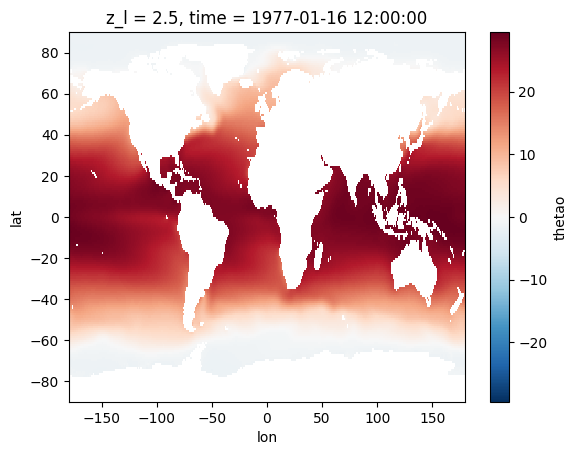

In [4]:
woa.thetao[0].plot()

# Read coarsened NYF data

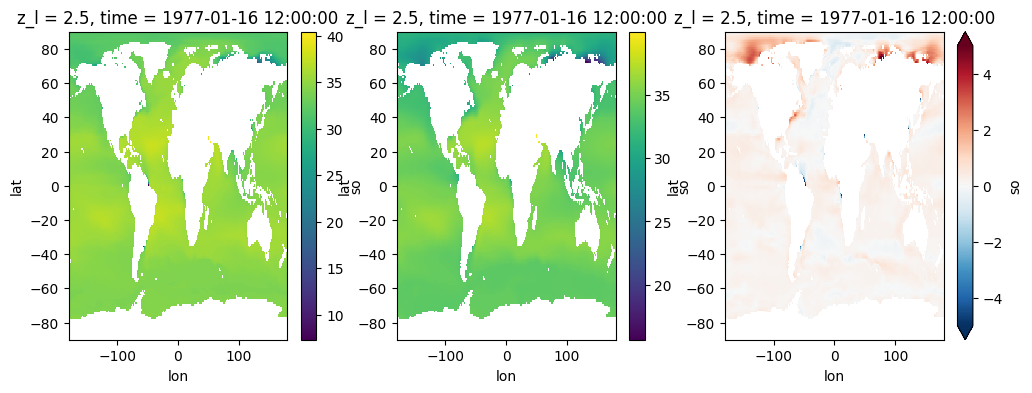

In [6]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
read_nyf_data().so[0].plot()
plt.subplot(1,3,2)
woa.so[0].plot()
plt.subplot(1,3,3)
(read_nyf_data().so[0]-woa.so[0]).plot(vmin=-5)

# Concatenate data to vectors
Each vector contains TnS data in 3D fields and has $2$ millions of points (precisely, 2053430)

In [27]:
d = TnS2vec(read_nyf_data(), woa, param, center=True)

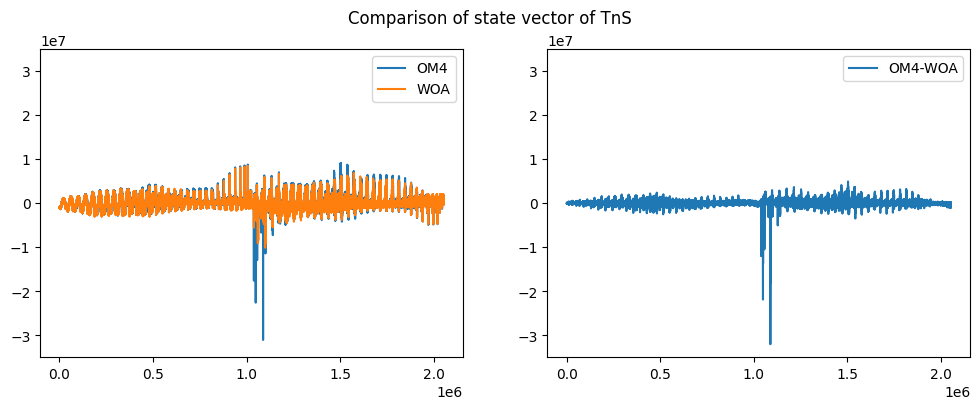

In [28]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(d['vector'], label='OM4')
plt.plot(d['vector_woa'], label='WOA')
plt.ylim([-3.5e+7, 3.5e+7])
plt.legend()
plt.subplot(1,2,2)
plt.plot(d['vector']-d['vector_woa'], label='OM4-WOA')
plt.suptitle('Comparison of state vector of TnS')
plt.ylim([-3.5e+7, 3.5e+7])
plt.legend()

# Compute model bias

In [9]:
regridder = return_regridder()

In [10]:
def read_calibration_data(exp='unparameterized'):
    path = f'/scratch/js15017/OM4_storage/CORE-AIF-runs/calibration/{exp}/*ocean_annual_z*'
    dataset = xr.open_mfdataset(path)[['thetao', 'so']].isel(time=slice(2,None)).mean('time')
    return (regridder(dataset) * param.mask_nan).compute()

In [11]:
control = read_calibration_data()

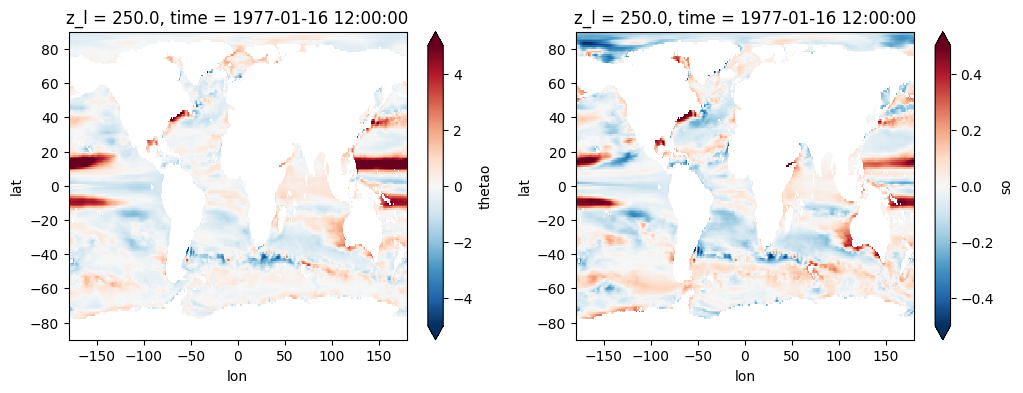

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
(control-woa).thetao[10].plot(vmin=-5)
plt.subplot(1,2,2)
(control-woa).so[10].plot(vmin=-0.5)

# Model error and Jacobian in vector space
Here model error is Control - WOA
responses are rows of jacobian

In [1186]:
kw = dict(max_depth=300)

In [1187]:
model_error = TnS2vec(control - woa, woa, param, **kw)

In [1188]:
smag_response = TnS2vec(read_nyf_data('unparameterized-0.09') - read_nyf_data('unparameterized'), woa, param, **kw)['vector'] / (0.09-0.06)

In [1189]:
vdiff_response = TnS2vec(read_nyf_data('unparameterized') - read_nyf_data('vert-diff'), woa, param, **kw)['vector'] / (1.5E-05 - 7.5E-06)

In [1190]:
gm_response = TnS2vec(read_nyf_data('GM') - read_nyf_data('unparameterized'), woa, param, **kw)['vector'] / (500 - 0)

In [1191]:
ann_response = TnS2vec(read_nyf_data('ANN-greenline') - read_nyf_data('unparameterized'), woa, param, **kw)['vector'] / (1. - 0.)

In [1192]:
zb_response = TnS2vec(read_nyf_data('ZB20-Klower') - read_nyf_data('unparameterized'), woa, param, **kw)['vector'] / (0.5 - 0.)

In [1193]:
variability_response = TnS2vec(read_nyf_data('ANN-greenline') - read_nyf_data('ANN-3x3-EXP2'), woa, param, **kw)['vector'] / (1. - 0.)

# Study significance of each reponse in affecting model error

In [1194]:
# 2000000x7 points
J_extended = np.vstack([smag_response, vdiff_response, gm_response, ann_response, zb_response, variability_response, model_error['vector']]
             ).T

In [1195]:
J_extended.shape

(833690, 7)

In [1196]:
JJT = J_extended.T@J_extended
normalization = np.diag(1/np.sqrt(np.diag(JJT)))

In [1197]:
np.set_printoptions(precision=2, suppress=True)
correlation_matrix = (normalization@JJT@normalization)
correlation_matrix

array([[ 1.  , -0.34,  0.36,  0.02,  0.18, -0.02, -0.01],
       [-0.34,  1.  , -0.14, -0.08, -0.19,  0.02,  0.02],
       [ 0.36, -0.14,  1.  ,  0.02,  0.21, -0.04, -0.14],
       [ 0.02, -0.08,  0.02,  1.  ,  0.73, -0.03, -0.17],
       [ 0.18, -0.19,  0.21,  0.73,  1.  , -0.09, -0.13],
       [-0.02,  0.02, -0.04, -0.03, -0.09,  1.  , -0.01],
       [-0.01,  0.02, -0.14, -0.17, -0.13, -0.01,  1.  ]])

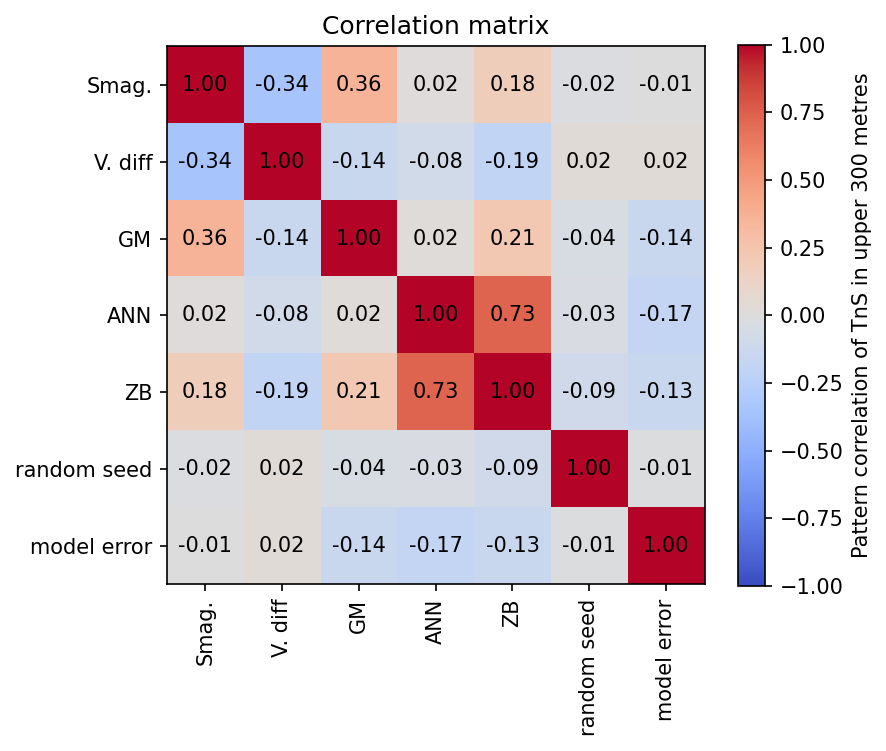

In [1198]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=150)

A = correlation_matrix.copy()

# Show heatmap
im = ax.imshow(A, cmap='coolwarm', vmin=-1.0, vmax=1.0)
plt.colorbar(im, label='Pattern correlation of TnS in upper 300 metres')

# Add text annotations
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        text = ax.text(j, i, f"{A[i, j]:.2f}",
                       ha="center", va="center", color="black", fontsize=10)

# Set labels and ticks
ax.set_xticks(np.arange(7))
ax.set_yticks(np.arange(7))
ax.set_xticklabels(['Smag.', 'V. diff', 'GM', 'ANN', 'ZB', 'random seed', 'model error'], rotation=90)
ax.set_yticklabels(['Smag.', 'V. diff', 'GM', 'ANN', 'ZB', 'random seed', 'model error'])
ax.set_title("Correlation matrix")

plt.tight_layout()

# Minimal step
We want to know what would be the minimal acceptable step in each parameter such that it's response is comparable to intermal variability give by random seed
For this, we solve the equation
$$
\delta u_j ||J[j]||_2 = ||random\_seed||_2
$$

In [1200]:
dsmag = np.linalg.norm(variability_response) / np.linalg.norm(smag_response)
print(dsmag)

0.03752984862278899


In [1201]:
dvdiff = np.linalg.norm(variability_response) / np.linalg.norm(vdiff_response)
print(dvdiff)

7.866297077521776e-06


In [1202]:
dgmdiff = np.linalg.norm(variability_response) / np.linalg.norm(gm_response)
print(dgmdiff)

177.16776240942866


In [1203]:
danndiff = np.linalg.norm(variability_response) / np.linalg.norm(ann_response)
print(danndiff)

0.39555423213793717


In [1204]:
dzbdiff = np.linalg.norm(variability_response) / np.linalg.norm(zb_response)
print(dzbdiff)

0.3336828937630264


# One Broyden step with different number of parameters

In [1205]:
J = np.vstack([
               #smag_response, 
               #vdiff_response, 
               gm_response, 
               ann_response
              ]
             ).T

In [1206]:
du = - np.linalg.inv(J.T@J)@J.T@model_error['vector']

In [1207]:
np.set_printoptions(precision=100,suppress=True)
du

array([133.73401905681231  ,   0.3847585022579782])

In [1208]:
# Expected improvement
np.linalg.norm(model_error['vector']+ J@du) / np.linalg.norm(model_error['vector'])

0.975548746582152

In [1209]:
(1 - 0.975548746582152)*100

2.445125341784804

# Vertical structure of model errors and responses

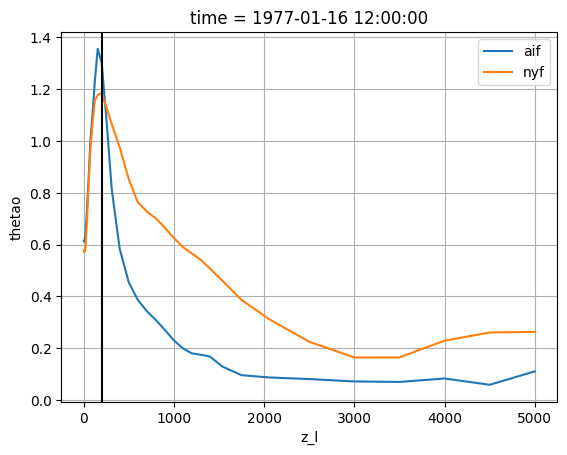

In [769]:
np.sqrt(((control-woa).thetao**2).mean(['lat', 'lon'])).plot(label='aif')
np.sqrt(((read_nyf_data()-woa).thetao**2).mean(['lat', 'lon'])).plot(label='nyf')
plt.legend()
plt.grid()
plt.axvline(x=200, color='k')

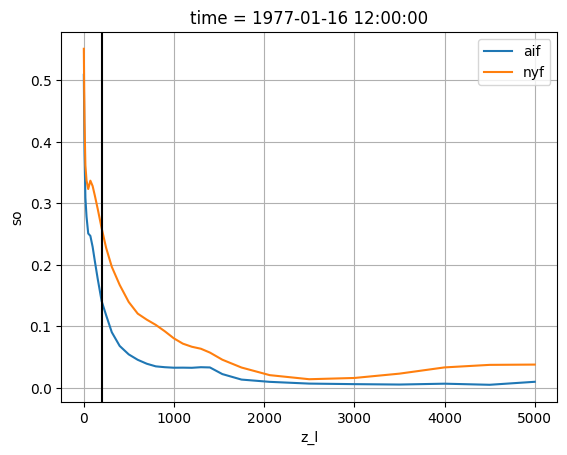

In [770]:
np.sqrt(((control-woa).so**2).mean(['lat', 'lon'])).plot(label='aif')
np.sqrt(((read_nyf_data()-woa).so**2).mean(['lat', 'lon'])).plot(label='nyf')
plt.legend()
plt.grid()
plt.axvline(x=200, color='k')

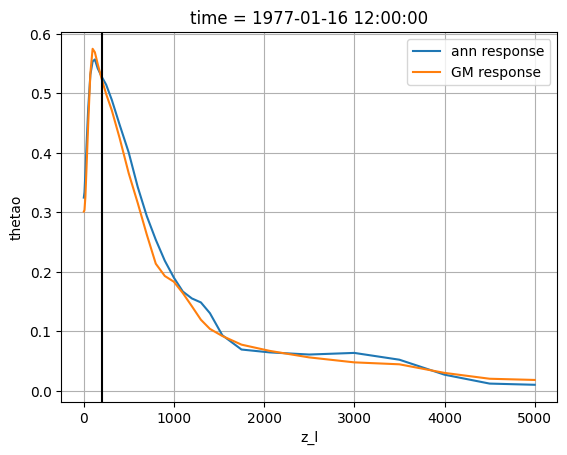

In [771]:
np.sqrt(((read_nyf_data('ANN-greenline') - read_nyf_data('unparameterized')).thetao**2).mean(['lat', 'lon'])).plot(label='ann response')
np.sqrt(((read_nyf_data('GM') - read_nyf_data('unparameterized')).thetao**2).mean(['lat', 'lon'])).plot(label='GM response')
plt.legend()
plt.grid()
plt.axvline(x=200, color='k')

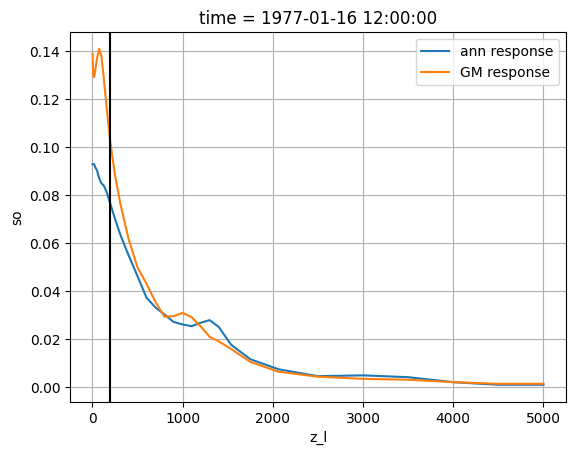

In [772]:
np.sqrt(((read_nyf_data('ANN-greenline') - read_nyf_data('unparameterized')).so**2).mean(['lat', 'lon'])).plot(label='ann response')
np.sqrt(((read_nyf_data('GM') - read_nyf_data('unparameterized')).so**2).mean(['lat', 'lon'])).plot(label='GM response')
plt.legend()
plt.grid()
plt.axvline(x=200, color='k')

# How bias compensation looks like (a priori)

In [4]:
gm_response = (read_nyf_data('GM') - read_nyf_data('unparameterized')) / 500 * 133.73401905681231

In [1211]:
ann_response = (read_nyf_data('ANN-greenline') - read_nyf_data('unparameterized')) / 1. * 0.3847585022579782

In [1212]:
model_error = (control - woa)

In [1213]:
expected_error = model_error + gm_response + ann_response

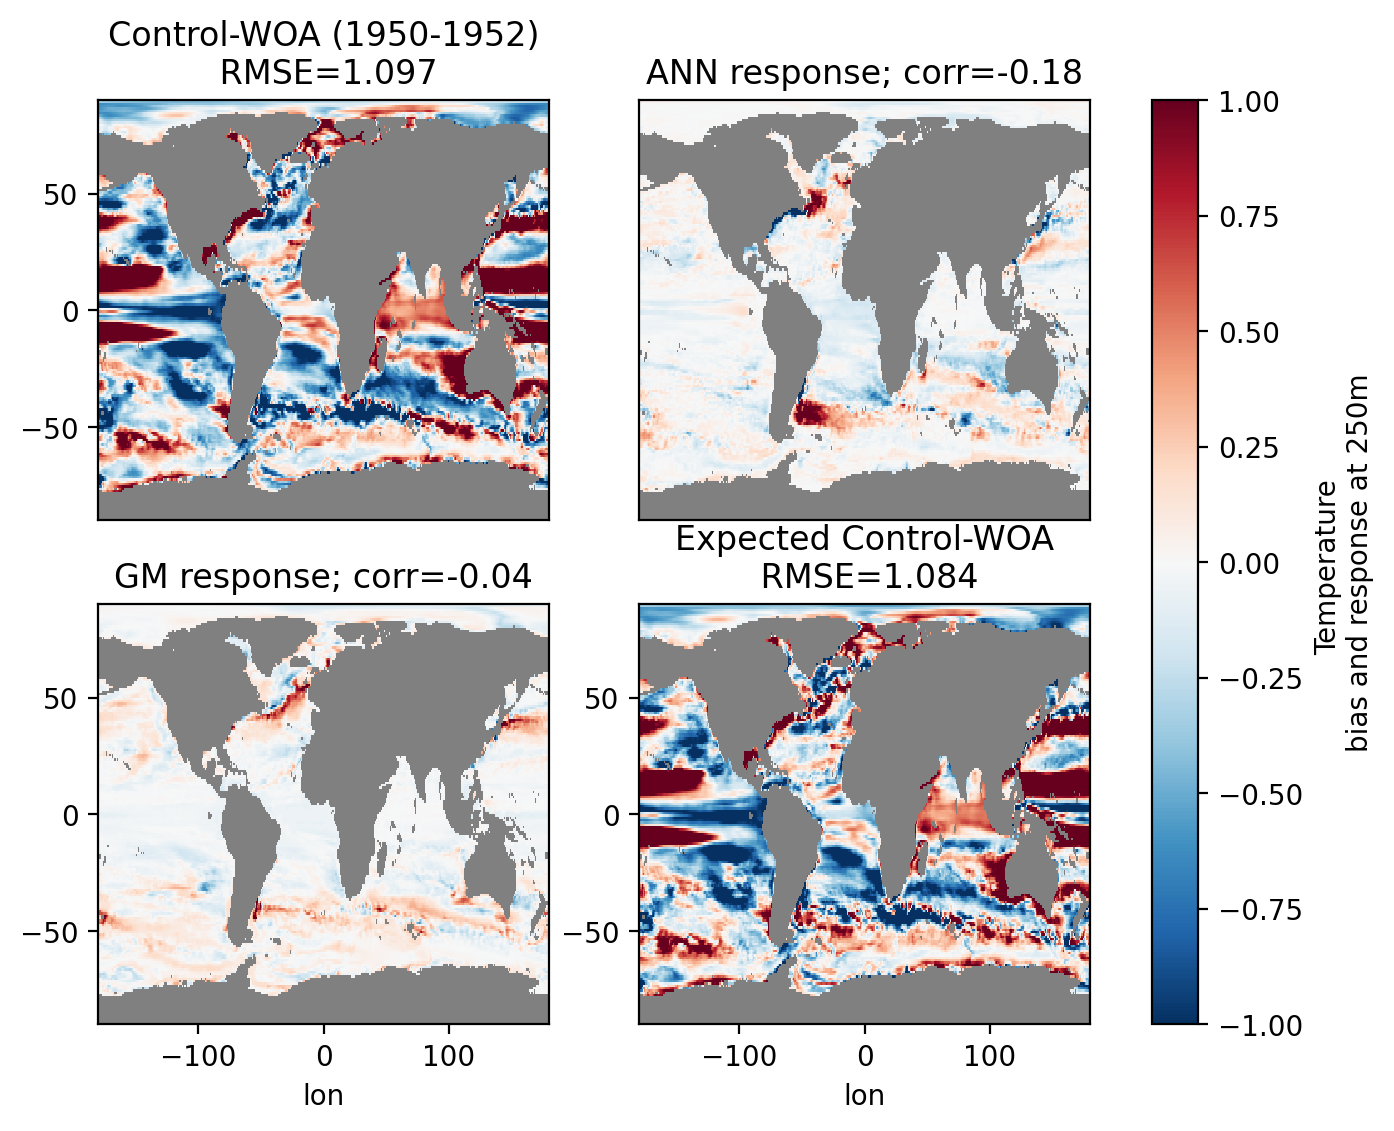

In [1263]:
plt.figure(figsize=(8,6), dpi=200)
plt.subplot(2,2,1)
model_error.thetao[10].plot(vmin=-1, add_colorbar=False)
rmse = float(np.sqrt((model_error.thetao[10]**2).mean()))
plt.title(f'Control-WOA (1950-1952)\n RMSE={round(rmse,3)}')
plt.gca().set_facecolor('gray')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.subplot(2,2,2)
ann_response.thetao[10].plot(vmin=-1, add_colorbar=False)
plt.gca().set_facecolor('gray')
plt.title('ANN response; corr=-0.18')
plt.ylabel('')
plt.yticks([])
plt.xticks([])
plt.xlabel('')
plt.subplot(2,2,3)
im = gm_response.thetao[10].plot(vmin=-1, add_colorbar=False)
plt.title('GM response; corr=-0.04')
plt.gca().set_facecolor('gray')
plt.ylabel('')
plt.subplot(2,2,4)
im = expected_error.thetao[10].plot(vmin=-1, add_colorbar=False)
rmse = float(np.sqrt((expected_error.thetao[10]**2).mean()))
plt.title(f'Expected Control-WOA\n RMSE={round(rmse,3)}')
plt.gca().set_facecolor('gray')
plt.ylabel('')

plt.colorbar(im, ax=plt.gcf().axes, label='Temperature \nbias and response at 250m')

In [5]:
gm_response = (read_nyf_data('GM') - read_nyf_data('unparameterized'))

In [6]:
ann_response = (read_nyf_data('ANN-greenline') - read_nyf_data('unparameterized'))

In [8]:
ann_gm_response = (read_nyf_data('GM-ANN') - read_nyf_data('unparameterized'))

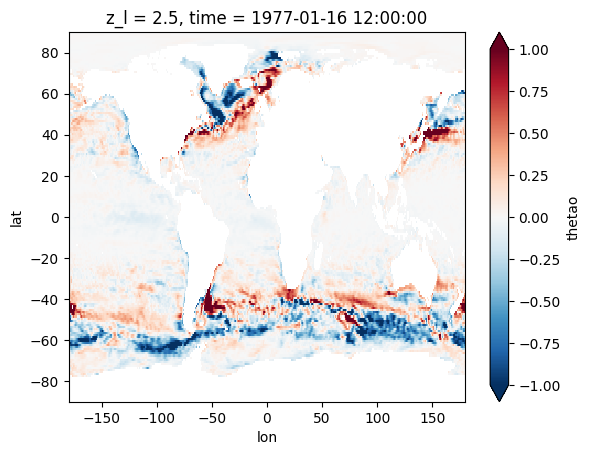

In [12]:
gm_response.thetao[0].plot(vmin=-5)

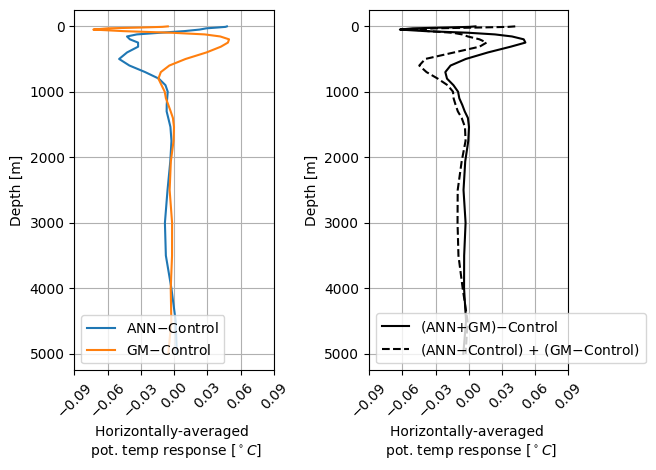

In [65]:
plt.subplot(1,2,1)
ave2d(ann_response.thetao, param).plot(label='ANN$-$Control', y='z_l')
ave2d(gm_response.thetao, param).plot(label='GM$-$Control', y='z_l')
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xticks(np.arange(-0.09,0.10,0.03), rotation=45)
plt.grid()
plt.xlabel('Horizontally-averaged \n pot. temp response [$^\\circ C$]')
plt.legend(loc='lower left')
plt.title('')

plt.subplot(1,2,2)
ave2d(ann_gm_response.thetao, param).plot(label='(ANN$+$GM)$-$Control', y='z_l', color='k')
ave2d((ann_response+gm_response).thetao, param).plot(label='(ANN$-$Control) $+$ (GM$-$Control)', y='z_l', color='k', ls='--')
plt.gca().invert_yaxis()
plt.xticks(np.arange(-0.09,0.10,0.03), rotation=45)
plt.xlabel('Horizontally-averaged \n pot. temp response [$^\\circ C$]')
plt.grid()
plt.ylabel('Depth [m]')
plt.legend(loc='lower left')
plt.title('')

plt.tight_layout()

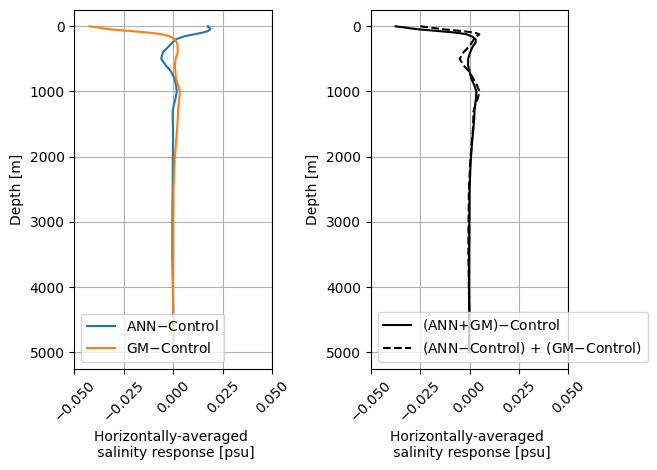

In [64]:
plt.subplot(1,2,1)
ave2d(ann_response.so, param).plot(label='ANN$-$Control', y='z_l')
ave2d(gm_response.so, param).plot(label='GM$-$Control', y='z_l')
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xticks(np.arange(-0.05,0.075,0.025), rotation=45)
plt.grid()
plt.xlabel('Horizontally-averaged \n salinity response [psu]')
plt.legend(loc='lower left')
plt.title('')

plt.subplot(1,2,2)
ave2d(ann_gm_response.so, param).plot(label='(ANN$+$GM)$-$Control', y='z_l', color='k')
ave2d((ann_response+gm_response).so, param).plot(label='(ANN$-$Control) $+$ (GM$-$Control)', y='z_l', color='k', ls='--')
plt.gca().invert_yaxis()
plt.xticks(np.arange(-0.05,0.075,0.025), rotation=45)
plt.xlabel('Horizontally-averaged \n salinity response [psu]')
plt.grid()
plt.ylabel('Depth [m]')
plt.legend(loc='lower left')
plt.title('')

plt.tight_layout()

Text(0.5, 0.93, 'Temperature response at depth 250m')

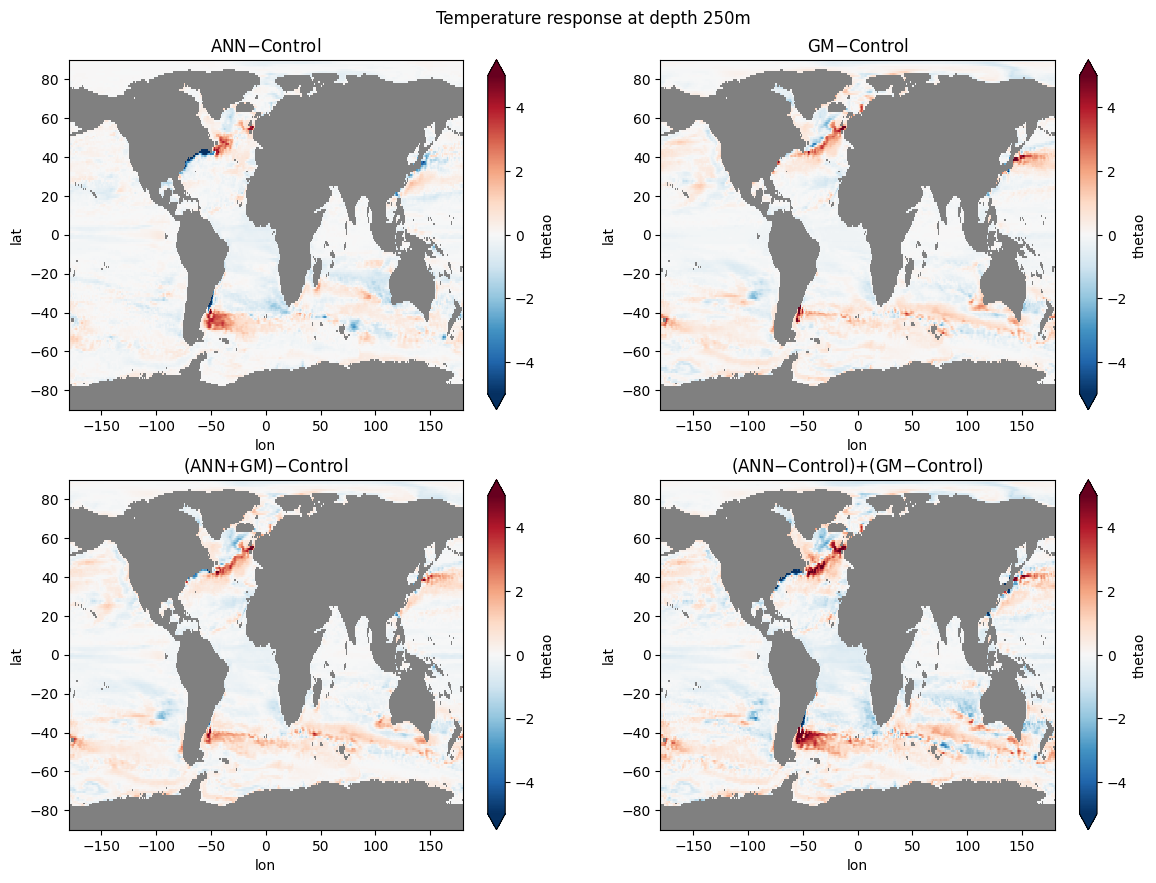

In [120]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
ann_response.thetao.isel(z_l=10).plot(vmin=-5)
plt.gca().set_facecolor('gray')
plt.title('ANN$-$Control')
plt.subplot(2,2,2)
gm_response.thetao.isel(z_l=10).plot(vmin=-5)
plt.gca().set_facecolor('gray')
plt.title('GM$-$Control')
plt.subplot(2,2,3)
ann_gm_response.thetao.isel(z_l=10).plot(vmin=-5)
plt.gca().set_facecolor('gray')
plt.title('(ANN+GM)$-$Control')
plt.subplot(2,2,4)
(ann_response+gm_response).thetao.isel(z_l=10).plot(vmin=-5)
plt.gca().set_facecolor('gray')
plt.title('(ANN$-$Control)$+$(GM$-$Control)')

plt.suptitle('Temperature response at depth 250m', y=0.93)

In [109]:
y = ann_gm_response.thetao.isel(z_l=10)
y_hat = (ann_response+gm_response).thetao.isel(z_l=10)
y1 = ann_response.thetao.isel(z_l=10)
y2 = gm_response.thetao.isel(z_l=10)

In [110]:
1 - np.mean((y-y_hat)**2) / np.mean((y)**2)

<xarray.DataArray 'thetao' ()> Size: 8B
array(0.16046441)
Coordinates:
    z_l      float64 8B 250.0
    time     object 8B 1977-01-16 12:00:00

In [111]:
1 - np.mean((y-y2)**2) / np.mean((y)**2)

<xarray.DataArray 'thetao' ()> Size: 8B
array(0.75999996)
Coordinates:
    z_l      float64 8B 250.0
    time     object 8B 1977-01-16 12:00:00

In [112]:
xr.corr(y, y_hat)

<xarray.DataArray 'thetao' ()> Size: 4B
array(0.8109231, dtype=float32)
Coordinates:
    z_l      float64 8B 250.0
    time     object 8B 1977-01-16 12:00:00

In [113]:
xr.corr(y, y2)

<xarray.DataArray 'thetao' ()> Size: 4B
array(0.8770052, dtype=float32)
Coordinates:
    z_l      float64 8B 250.0
    time     object 8B 1977-01-16 12:00:00

In [114]:
xr.corr(y, y1)

<xarray.DataArray 'thetao' ()> Size: 4B
array(0.35650048, dtype=float32)
Coordinates:
    z_l      float64 8B 250.0
    time     object 8B 1977-01-16 12:00:00

Text(0.5, 0.93, 'Salinity response at depth 250m')

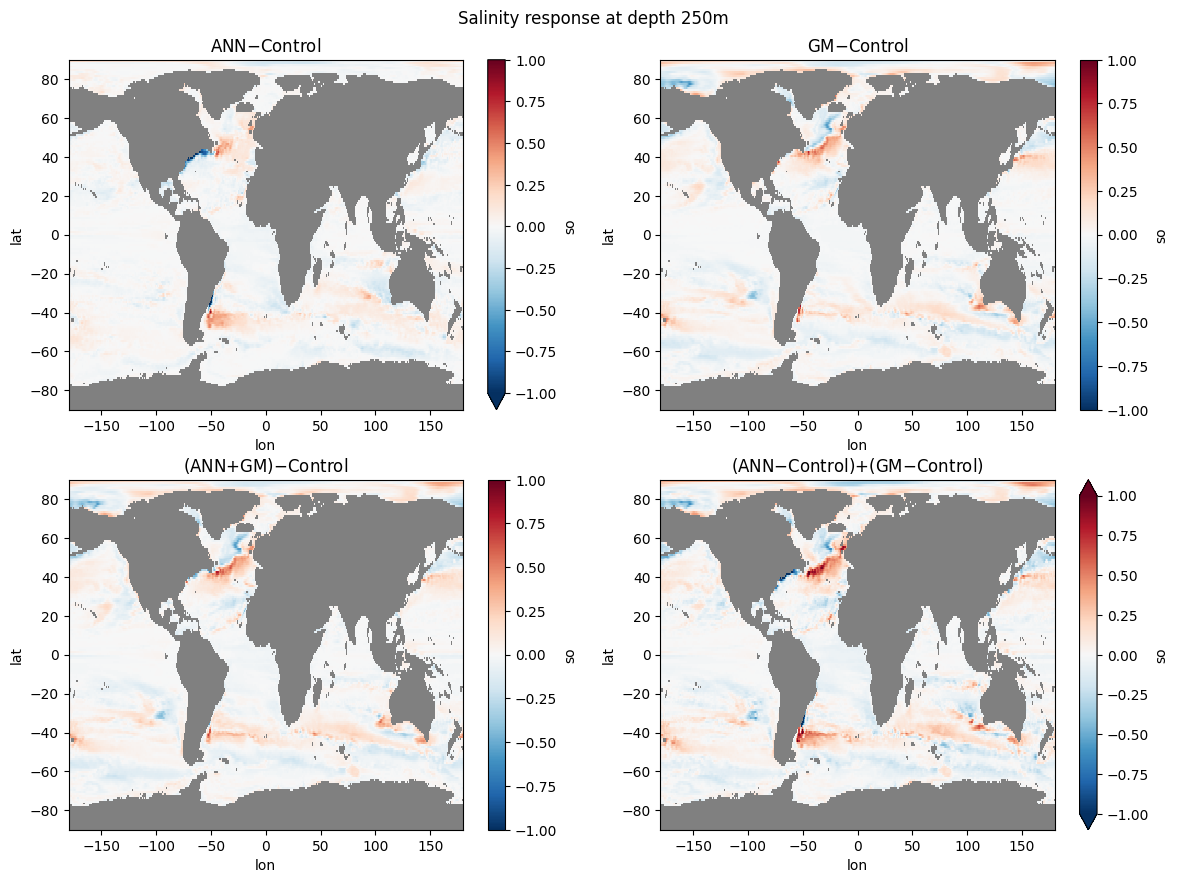

In [123]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
ann_response.so.isel(z_l=10).plot(vmin=-1)
plt.gca().set_facecolor('gray')
plt.title('ANN$-$Control')
plt.subplot(2,2,2)
gm_response.so.isel(z_l=10).plot(vmin=-1)
plt.gca().set_facecolor('gray')
plt.title('GM$-$Control')
plt.subplot(2,2,3)
ann_gm_response.so.isel(z_l=10).plot(vmin=-1)
plt.gca().set_facecolor('gray')
plt.title('(ANN+GM)$-$Control')
plt.subplot(2,2,4)
(ann_response+gm_response).so.isel(z_l=10).plot(vmin=-1)
plt.gca().set_facecolor('gray')
plt.title('(ANN$-$Control)$+$(GM$-$Control)')

plt.suptitle('Salinity response at depth 250m', y=0.93)

In [124]:
y = ann_gm_response.so.isel(z_l=10)
y_hat = (ann_response+gm_response).so.isel(z_l=10)
y1 = ann_response.so.isel(z_l=10)
y2 = gm_response.so.isel(z_l=10)

In [125]:
1 - np.mean((y-y_hat)**2) / np.mean((y)**2)

<xarray.DataArray 'so' ()> Size: 8B
array(0.47350764)
Coordinates:
    z_l      float64 8B 250.0
    time     object 8B 1977-01-16 12:00:00

In [126]:
1 - np.mean((y-y2)**2) / np.mean((y)**2)

<xarray.DataArray 'so' ()> Size: 8B
array(0.84853107)
Coordinates:
    z_l      float64 8B 250.0
    time     object 8B 1977-01-16 12:00:00

In [127]:
xr.corr(y, y_hat)

<xarray.DataArray 'so' ()> Size: 4B
array(0.8439181, dtype=float32)
Coordinates:
    z_l      float64 8B 250.0
    time     object 8B 1977-01-16 12:00:00

In [128]:
xr.corr(y, y2)

<xarray.DataArray 'so' ()> Size: 4B
array(0.92332155, dtype=float32)
Coordinates:
    z_l      float64 8B 250.0
    time     object 8B 1977-01-16 12:00:00

In [129]:
xr.corr(y, y1)

<xarray.DataArray 'so' ()> Size: 4B
array(0.27561197, dtype=float32)
Coordinates:
    z_l      float64 8B 250.0
    time     object 8B 1977-01-16 12:00:00